In [1]:
import glob, os, pickle, datetime
import xgrads
import xarray as xa
from matplotlib import pyplot as plt
import numpy as np
from dask.distributed import Client

# def getTimes(pathname):
#     ctl = xgrads.CtlDescriptor(file=pathname)
#     ctl=fixTime(ctl)
#     return (ctl.tdef.samples)

def fixTime(ctl):
    dt2000secs=round((datetime.datetime(2000,1,1)-datetime.datetime(1,1,1)).total_seconds())    
    ctl.tdef.samples=ctl.tdef.samples+dt2000secs
    return(ctl)

def getCtlList(varname):
    pathlist=glob.glob('ape_2/cntl/??????????/' + varname + '.ctl',recursive=True)
    #build list of ctl objects for readin grads data
    ctlListt2000=[fixTime(xgrads.CtlDescriptor(file=path)) for path in pathlist]
    return(ctlListt2000)

def getVarTimeMean(varname):
    pathlist=glob.glob('interm/' + varname + '/*' + varname + '.tmean.nc',recursive=True)
    #need to add time coord to tmean files (length 1) to permit multifile open along time axis
    def preprocessing(ds): 
        return(ds.expand_dims(dim={'t':[np.datetime64(ds.attrs['t0'])]}))
    ds = xa.open_mfdataset(pathlist, concat_dim='t',combine='by_coords', preprocess = preprocessing)
    ds_tmean=ds.mean(dim='t').compute()
    return ds_tmean[varname]

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35883 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 12.38 GiB


In [3]:
# z=0 
# initially I tried doing this by level, but it wasn't much faster (if at all) than 
# doing the whole thing
TctlList=getCtlList('T')
Tds=xgrads.open_mfdataset(TctlList)
Tz=Tds.T[:,:,:,:]
Tzmean=getVarTimeMean('T')[:,:,:]

VctlList=getCtlList('V')
Vds=xgrads.open_mfdataset(VctlList)
Vz=Vds.V[:,:,:,:]
Vzmean=getVarTimeMean('V')[:,:,:]

Tzprime=Tz-Tzmean
Vzprime=Vz-Vzmean

Tzprime=Tzprime.chunk('auto')
Vzprime=Vzprime.chunk('auto')
print(Tzprime)
print(Vzprime)

<xarray.DataArray 'T' (time: 20120, lev: 56, lat: 120, lon: 240)>
dask.array<rechunk-merge, shape=(20120, 56, 120, 240), dtype=float32, chunksize=(20, 56, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T06:00:00 ... 2013-12-20
  * lev      (lev) float64 0.9946 0.9834 0.9713 ... 0.0003619 9.157e-05
  * lat      (lat) float64 -88.86 -87.38 -85.89 -84.39 ... 85.89 87.38 88.86
  * lon      (lon) float32 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
<xarray.DataArray 'V' (time: 20120, lev: 56, lat: 120, lon: 240)>
dask.array<rechunk-merge, shape=(20120, 56, 120, 240), dtype=float32, chunksize=(20, 56, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T06:00:00 ... 2013-12-20
  * lev      (lev) float64 0.9946 0.9834 0.9713 ... 0.0003619 9.157e-05
  * lat      (lat) float64 -88.86 -87.38 -85.89 -84.39 ... 85.89 87.38 88.86
  * lon      (lon) float32 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.

In [4]:
VT=(Tzprime*Vzprime).mean(dim='time')
VT

<xarray.DataArray (lev: 56, lat: 120, lon: 240)>
dask.array<mean_agg-aggregate, shape=(56, 120, 240), dtype=float32, chunksize=(56, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.9946 0.9834 0.9713 ... 0.0003619 9.157e-05
  * lat      (lat) float64 -88.86 -87.38 -85.89 -84.39 ... 85.89 87.38 88.86
  * lon      (lon) float32 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [ ]:
# this takes hours...
# doesn't seem significantly faster to do it for a single level so may as well do the whole thing
VT.compute()

In [ ]:
# VT is a dataarray at this point so convert to dataset for storing as nc or it gets a weird 
# default variable name which you have to use later
VT.to_dataset(name='VpTp').to_netcdf('VT.nc')

In [11]:
VT=xa.open_dataset('VT.nc')
VT

<xarray.Dataset>
Dimensions:  (lat: 120, lev: 56, lon: 240)
Coordinates:
  * lev      (lev) float64 0.9946 0.9834 0.9713 ... 0.0003619 9.157e-05
  * lat      (lat) float64 -88.86 -87.38 -85.89 -84.39 ... 85.89 87.38 88.86
  * lon      (lon) float32 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    VpTp     (lev, lat, lon) float32 ...

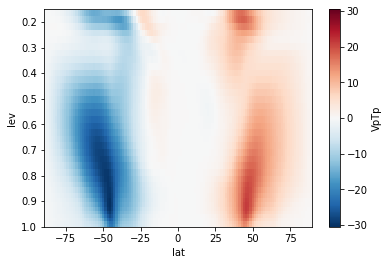

In [12]:
zmin=0.15
yr=(1,zmin)
VT.VpTp.loc[1:zmin,:,:].mean(dim='lon').plot(ylim=yr);